# Deep Learning for NLP - Project
# Sarah Hegazy

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [45]:
import io
import os
import numpy as np
import scipy

In [46]:
PATH_TO_DATA = os.path.normpath("C:/Users/hegaz/Documents/Classes/Deep Learning/nlp_project/data/")

# 1) Monolingual (English) word embeddings 

In [47]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        self.similar_scores =[]
        
        for wrd in self.word2id.keys():
            self.similar_scores.append(self.score(wrd,w))
        wrd_ind = np.argsort(self.similar_scores)[::-1][1:K+1]
        s =[]
        for i in wrd_ind:
            s.append(list(self.word2id.keys())[i])
        return s

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        w1=self.word2vec[w1]
        w2=self.word2vec[w2]
        dot_product = np.dot(w1, w2)
        norm_1 = np.linalg.norm(w1)
        norm_2 = np.linalg.norm(w2)
        return (dot_product / (norm_1 * norm_2))

In [48]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=250000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'parisian', 'london', 'berlin']
['austria', 'europe', 'german', 'berlin', 'poland']


In [49]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                list_b = []
                for w in set(sent.split()):
                    list_b.append(self.w2v.word2vec.get(w, np.zeros((300,))))
                total = 0
                for v in list_b:
                    total += v
                sentemb.append(total/len(list_b))
                
            else:
                # idf-weighted mean of word vectors
                list_b = []
                for w in set(sent.split()):
                    list_b.append(np.dot(self.w2v.word2vec.get(w, np.zeros((300,))), idf.get(w, 0)))
                total = 0
                for v in list_b:
                    total += v
                sentemb.append(total/len(list_b))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        
        list_of_score = np.array([])
        
        for i in range(len(keys)):
            list_of_score = np.concatenate((list_of_score, [self.score(s, sentences[i], idf)]), axis=0)
        
        sorted_index = np.argsort(-list_of_score)
        sim = []
        for j in range(1, K+1):
            sim.append(sentences[sorted_index[j]])    
        return sim

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        
        e_s1 = self.encode([s1], idf)[0]
        e_s2 = self.encode([s2], idf)[0]

        
        return np.dot(e_s1, e_s2) / (np.linalg.norm(e_s1)*np.linalg.norm(e_s2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        for word in list(idf.keys()):
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf

In [50]:

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'), encoding='utf-8') as f:
    sentences = list(f)

no_idf = True   

# Build idf scores for each word
idf = {} if no_idf else s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print('' if not sentences else sentences[10], s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print('' if not sentences else sentences[7], '' if not sentences else sentences[13], s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


no_idf = False

idf = {} if no_idf else s2v.build_idf(sentences) 
print('' if not sentences else sentences[10], s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf
print('' if not sentences else sentences[7], '' if not sentences else sentences[13], s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors


C:\Users\hegaz\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


1 smiling african american boy . 
 ['blond boy waterskiing . \n', 'a boy surfs . \n', 'a boy jumps . \n', 'a boy jumps . \n', 'a boy screams . \n']
1 man singing and 1 man playing a saxophone in a concert . 
 10 people venture out to go crosscountry skiing . 
 0.59267750530178
1 smiling african american boy . 
 ['a man rides a 4 wheeler in the desert . \n', '5 women and 1 man are smiling for the camera . \n', '3 males and 1 woman enjoying a sporting event \n', 'a man in black is juggling 3 flamed bottles . \n', 'a young boy in the water in 2 floating tubes . \n']
1 man singing and 1 man playing a saxophone in a concert . 
 10 people venture out to go crosscountry skiing . 
 0.5354923843214624


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [11]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
text_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
text_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [12]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)
def identical_words(dict1,dict2):
    l_word1 = set(dict1.word2vec.keys())
    l_word2 = dict2.word2vec.keys()
    return [word for word in l_word2 if word in l_word1]
    
def matrix(dict_world, list_words):
    X = []
    for word in list_words:
        X.append(dict_world.word2vec[word])
    return np.array(X).T

list_words = identical_words(text_en, text_fr)
X = matrix(text_fr, list_words)
Y = matrix(text_en, list_words)

In [13]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

import scipy.linalg as spl

# TYPE CODE HERE

U,s,Vh = spl.svd(np.dot(Y,X.T))
W = np.dot(U,Vh)
W

array([[-0.16472129, -0.02480074,  0.02065991, ..., -0.03685242,
         0.01650765, -0.01410498],
       [-0.0513787 , -0.03803497,  0.11145456, ..., -0.00428417,
        -0.04856031,  0.01366349],
       [-0.01016405, -0.07118315, -0.04736305, ...,  0.01406463,
        -0.06342835,  0.05156119],
       ...,
       [ 0.13092349,  0.00226426,  0.03636042, ..., -0.00637256,
         0.06492084, -0.00088374],
       [ 0.04778835,  0.05628567,  0.01371082, ..., -0.03636385,
        -0.03775559,  0.02193114],
       [ 0.01460412, -0.09013019, -0.07652912, ..., -0.01826499,
        -0.04055227, -0.04305727]])

In [14]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# translating from french to english 
print('French 2 English :')
for w1 in ['crevettes', 'voiture', 'ciel','chaussures']:
    en = np.dot(W,text_fr.word2vec[w1])
    text_en.word2vec['added_french_word'] = en
    print(w1,text_en.most_similar('added_french_word'))
    
# Translation from english to french
print('English 2 French :')
for w1 in ['lion', 'videogame', 'friend', 'bear']:
    fr = np.dot(W.T,text_en.word2vec[w1])
    text_fr.word2vec['added_english_word'] = fr
    print(w1,text_fr.most_similar('added_english_word'))

French 2 English :
crevettes ['oysters', 'mussels', 'clams', 'crustaceans', 'mackerel']
voiture ['cars', 'limousine', 'suv', 'roadster', 'truck']
ciel ['sky', 'skies', 'skyscrapers', 'heavens', 'earth']
chaussures ['footwear', 'clothing', 'apparel', 'underwear', 'boots']
English 2 French :
lion ['léopard', 'éléphant', 'lions', 'elephant', 'griffon']
videogame ['vidéoludique', 'playstation', 'gameplay', 'nintendo', 'jeu']
friend ['amie', 'friend', 'camarade', 'admirateur', 'confident']
bear ['ours', 'grizzly', 'elephant', 'bison', 'badger']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [35]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE

def load_file(path):
    with open(path, encoding='utf-8') as f:
        return f.read()

    
test_d = load_file('data/SST/stsa.fine.test.X')
train_d = load_file('data/SST/stsa.fine.train')
dev_d = load_file('data/SST/stsa.fine.dev')

In [66]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
idf = s2v.build_idf(train_d.split('\n')) 

train = []
train_labels = []
train_idf = []
test = []
test_idf = []
dev = []
dev_labels = []
dev_idf = []

for d in train_d.split('\n'):
    try:
        label = d[0]
        sentence = d[2:]

        a = s2v.encode([sentence])
        train.append(a[0])
        train_labels.append(int(label))
        a = s2v.encode([sentence], idf)
        train_idf.append(a[0])
    except:
        pass
    

for d in dev_d.split('\n'):  
    try:
        label = d[0]
        sentence = d[2:]

        a = s2v.encode([sentence])
        dev.append(a[0])
        dev_labels.append(int(label))
        a = s2v.encode([sentence], idf)
        dev_idf.append(a[0])
    except:
        pass
    
for d in test_d.split('\n'):
    try:
        a = s2v.encode([d])
        test.append(a[0])
        a = s2v.encode([d], idf)
        test_idf.append(a[0])
    except:
        pass

print(train_labels[0:20])


[4, 1, 1, 2, 3, 2, 3, 3, 1, 4, 1, 1, 3, 1, 1, 4, 3, 3, 1, 4]


In [70]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score

l_reg = LogisticRegression(random_state=42, solver='lbfgs',
                         multi_class='multinomial').fit(train, train_labels)
l_reg.fit(train, train_labels)
print('Training set accuracy:',(accuracy_score(train_labels, l_reg.predict(train)))*100)
print('Development set accuracy:', (accuracy_score(dev_labels, l_reg.predict(dev)))*100)



C:\Users\hegaz\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training set accuracy: 43.21161048689138
Development set accuracy: 38.23796548592189


C:\Users\hegaz\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [68]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

predictions = l_reg.predict(test[:2210])

print(predictions[:5])
with open("logreg_bov_y_test_sst.txt", 'w') as file:
    for pred in predictions:
        file.write(str(pred) + '\n')

[1 3 2 1 1]


In [72]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE


from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


l_reg2 = LogisticRegression(penalty='l2', multi_class='multinomial', solver='sag')

# Create regularization hyperparameter space
C = np.logspace(0, 3, 5)

hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
GS = GridSearchCV(l_reg2, hyperparameters, cv=5, verbose=0)

# Grid Search
GS.fit(train, train_labels)
print('Best C:', GS.best_estimator_.get_params()['C'])

print('training set accuracy: ', GS.score(train, train_labels))
print('development set accuracy: ', GS.score(dev, dev_labels))

with open("logreg2_bov_y_test_sst.txt", 'w') as file:
    for pred in predictions:
        file.write(str(pred) + '\n')



C:\Users\hegaz\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hegaz\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hegaz\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hegaz\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\hegaz\Anaconda3\envs\py35\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The ma

Best C: 1.0
training set accuracy:  0.43082865168539325
development set accuracy:  0.38056312443233425


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [3]:
import keras

Using TensorFlow backend.


In [93]:
# 1 - Load train/dev/test sets of SST
from keras.utils import to_categorical
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "C:/Users/hegaz/Documents/Classes/Deep Learning/nlp_project/data/SST"

# TYPE CODE HERE
def load_dataset(name):
    if name == 'stsa.fine.test.X':
        return [line.rstrip('\n') for line in open(os.path.join(PATH_TO_DATA, name))]
    else : 
        s = [line.rstrip('\n') for line in open(os.path.join(PATH_TO_DATA, name))]
        label = np.array([int(sentence[0]) for sentence in s])
        sent = [sentence[2:] for sentence in s]
        return sent, label


# TYPE CODE HERE
X_train, Y_train = load_dataset('stsa.fine.train')
Y_train = to_categorical(Y_train)
X_dev, Y_dev = load_dataset('stsa.fine.dev')
Y_dev = to_categorical(Y_dev)
X_test = load_dataset('stsa.fine.test.X')

In [94]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE

def process(sentence_list, vocab_size):
    return [keras.preprocessing.text.one_hot(sentence, vocab_size) for sentence in sentence_list]

vocab_size = 5000
encode_train = process(X_train, vocab_size)
encode_dev = process(X_dev, vocab_size)
encode_test = process(X_test, vocab_size)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [95]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/
from keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(encode_train)
X_dev = pad_sequences(encode_dev)
X_test =pad_sequences(encode_test)


## 4.2 - Design and train your model

In [96]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout,GlobalMaxPooling1D

from keras.regularizers import l2, l1

embed_dim  = 32  # word embedding dimension
nhid       = 128  # number of hidden units in the LSTM
vocab_size = 5000 # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1)))
model.add(Dense(n_classes, activation='softmax'))


In [97]:
# 5 - Define your loss/optimizer/metrics
from keras import optimizers
# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy'
optimizer        = optimizers.Adam(lr=0.001)
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 32)          160000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 645       
Total params: 243,077
Trainable params: 243,077
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
# ADAPT CODE BELOW
bs = 32
n_epochs = 6

history = model.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev,Y_dev))


Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 19s 2ms/step - loss: 3.5285 - acc: 0.2639 - val_loss: 1.5749 - val_acc: 0.2534
Epoch 2/6
8544/8544 [==============================] - 16s 2ms/step - loss: 1.5696 - acc: 0.2762 - val_loss: 1.5747 - val_acc: 0.2625
Epoch 3/6
8544/8544 [==============================] - 16s 2ms/step - loss: 1.5697 - acc: 0.2711 - val_loss: 1.5758 - val_acc: 0.2534
Epoch 4/6
8544/8544 [==============================] - 16s 2ms/step - loss: 1.5664 - acc: 0.3008 - val_loss: 1.5657 - val_acc: 0.3361
Epoch 5/6
8544/8544 [==============================] - 16s 2ms/step - loss: 1.4837 - acc: 0.3858 - val_loss: 1.4976 - val_acc: 0.3569
Epoch 6/6
8544/8544 [==============================] - 16s 2ms/step - loss: 1.3632 - acc: 0.4277 - val_loss: 1.4932 - val_acc: 0.3597


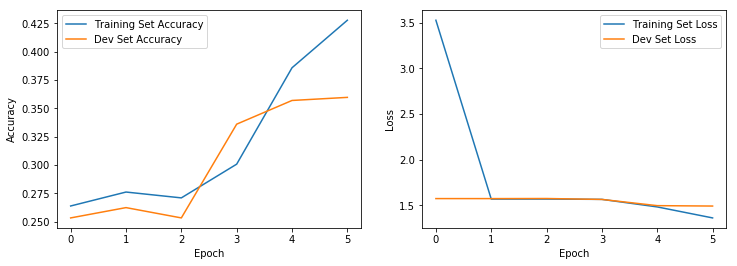

In [63]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# ADAPT CODE BELOW
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["acc"], label="Training Set Accuracy")
plt.plot(history.history["val_acc"], label="Dev Set Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Set Loss")
plt.plot(history.history["val_loss"], label="Dev Set Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

y_test_pred = model.predict(X_test)
text_to_write = "\n".join(y_test_pred.max(axis=1).astype(str))
f = open("logreg_lstm_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()

## 4.3 -- innovate !

In [106]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

embed_dim  = 32      # word embedding dimension
vocab_size = 5000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Conv1D(32, 5, activation='relu', padding='same'))
model.add(Conv1D(32, 5, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_classes, activation='sigmoid'))
model.add(Dense(n_classes, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

model.compile(loss=loss_classif,optimizer='rmsprop',metrics=metrics_classif)
print(model.summary())

bs = 32
n_epochs = 6

history = model.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, Y_dev))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, None, 32)          160000    
_________________________________________________________________
conv1d_33 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_34 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 5)                 165       
_________________________________________________________________
dense_59 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_60 (Dense)             (None, 5)                 30        
Total para

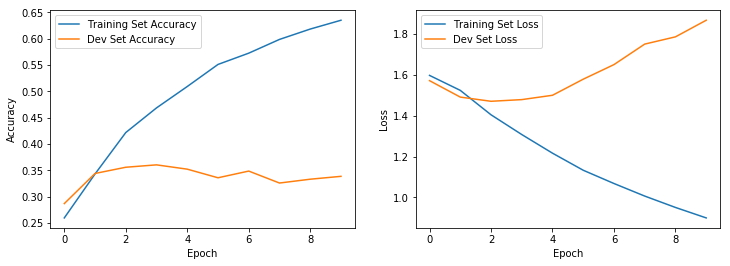

In [100]:
# plot and save y_test

y_test_pred = model.predict(X_test)
text_to_write = "\n".join(y_test_pred.max(axis=1).astype(str))
f = open("logreginnovate_lstm_y_test_sst.txt", "w")
f.write(text_to_write)
f.close()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["acc"], label="Training Set Accuracy")
plt.plot(history.history["val_acc"], label="Dev Set Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Set Loss")
plt.plot(history.history["val_loss"], label="Dev Set Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()